In [ ]:
!pip install agentpy

In [1]:
#All neccesary imports:
import agentpy as ap
import numpy as np
import random

### Internal State
Here I created a Class for the Internal States, you can use a dictionary or even a list.

In [2]:
class InternalState():
    def __init__(self,initPos):
        self.dirt = False   #Belief: Is it dirty on my position?
        self.x = initPos[0] #Belief: agent position X (as Belief)
        self.y = initPos[1] #Belief: agent position Y (as Belief)
        self.limx = -1      #Belief: world limit X
        self.limy = -1      #Belief: world limit Y
        self.dir = 0        #Belief: current Direction
        #Here the direction is a number from 0 to 3, meanning from North to West (ClockWise)

### Grid (The World)

Here I created my own grid environment for the purpose of the simulation. If you need a grid environment you can create your own or you can use the AgentPy Grid (ap.Grid()).

In [3]:
class Grid():
    def __init__(self,size,dirties):
        self.map = []                   #Define a squared map as a list
        self.size = size                #Define the size of the grid
        self.length = size[0]*size[1]   #Define the amount of spaces on the grid
        self.dirties = dirties          #Define the amount of dirty spaces
        self.build()                    #Fill the Grid (randomly) with the defined amount of dirty spaces

    def isDirty(self,x,y):              #Is the space X, Y dirty?
        return self.map[y][x] == 1

    def clean(self,x,y):          #Convert the space X, Y to a clean space
        self.map[y][x] = 0
        self.dirties-=1           #Reduce the number of dirty spaces

    def build(self):                #To build the Grid
        d = 0
        places = []
        for _ in range(self.length): # length is width*length, so this for loop will yield a very long list of 1s and 0s.
            if d <= self.dirties:
                places.append(1)
                d+=1
            else:
                places.append(0)
        random.shuffle(places) # shuffle randomly the list of 1s and 0s.
        k = 0
        for j in range(self.size[1]): # for each column
            self.map.append([]) # append a new empty list representing the column
            for i in range(self.size[0]): # for each row
                self.map[j].append(places[k]) # append a 1 or a 0.
                k+=1
        self.printMap()

    def printMap(self):                         #Here you can print the grid as 0's and 1's ('1' means dirty)
        s = ''
        for j in range(self.size[1]):
            for i in range(self.size[0]):
                s += str(self.map[j][i])+','
            s+='\n'
        print(s)

    def utility(self):          #Calculate the utility
        return 1 - (self.dirties/self.length)   #Complement of: Number of dirty spaces by the total of spaces


### The Agent

Now I declared my VaccumAgent. This agent moves randomly. If its space is dirty it will clean it and move to another space. The agent cannot move beyond the limits of the Grid.

In [4]:
class VaccumAgent(ap.Agent):

    """ An agent that cleans the floor 
        The agents main methods: setup, step (optional), update (optional) and end (optional)
    """

    def setup(self):
        initPos = (0,0)     #Initial position of the agent
        self.i = InternalState(initPos) #Adds the Internal States

    #Here I added a step() function for better organization and readability, but it is not necessary
    def step(self):                     #The whole action() funtion
        # model instance is inherited from ap.Agent superclass which has access to ap.Model class
        p = self.see(self.model.world)
        self.next(p)
        self.action()

    #I also added the update function for the same purpose. Of course I don't even use it
    def update(self):
        pass

    #Same as before
    def end(self):
        pass

#-------------------------------------------------------------------
#The agent's complementary methods:

    def see(self,e):
        p = e.isDirty(self.i.x,self.i.y) #The percept is just if the agent see's the space dirty or not.
        return p
    
    def next(self, p):
        self.i.dirt = p  # I update my Internal States using my Percepts
        #Of course, the only part that matters here from my Internal State is if the space is dirty or not.

    def action(self):
        if self.i.dirt:     # If it's dirty, then clean the floor
            self.model.world.clean(self.i.x,self.i.y)
        self.move()         #Then move

    #How does the agent move?
    def move(self):
        if random.randint(0,1) == 1: # 50-50 random decision to right-turn or not
            self.i.dir = (self.i.dir + 1) % 4 # Then turn to the right
        # Next, it will move to that direction, only if it is not beyond the limit:
        if self.i.dir == 0 and self.i.y - 1 >= 0: # top barrier
            self.i.y -= 1
        elif self.i.dir == 1 and self.i.x + 1 < self.i.limx: # right barrier
            self.i.x += 1
        elif self.i.dir == 2 and self.i.y + 1 < self.i.limy: # bottom barrier
            self.i.y += 1
        if self.i.dir == 3 and self.i.x - 1 >= 0: # left barrier
            self.i.x -= 1

### The Model

Here I defined my VaccumModel. I am recording an utility based on the amount of dirty spaces over time.

In [5]:
class VaccumModel(ap.Model):
    ''' The model's main methods: setup, step, update and end '''

    def setup(self):
        ''' Initialization '''
        self.steps = 0  #current steps
        self.optimalSteps = self.steps #Steps of higher utility
        self.foundOptimal = False
        self.world = Grid((10,10),10)   #Create grid world
        self.agents = ap.AgentList(self, self.p.agents, VaccumAgent)    #Create agents
        for agent in self.agents:   #add world limits to the agent's beliefs
            agent.i.limx = self.world.size[0]
            agent.i.limy = self.world.size[1]

    #For each step of the simulation...
    def step(self):
        self.agents.step()  #Do the agent's step
        self.steps += 1     #Increase the amount of steps

    #At the end of each step...
    def update(self):
        u = self.model.world.utility()      # Calculate the utility
        self.record('Utility Over time', u) # Record utility into a log named "Utility Over time"
        if u >= 1 and not self.foundOptimal:    #If it is the maximum utility then:
            self.optimalSteps = self.steps      #Store the number of steps
            self.foundOptimal = True

    #At the end of the simulation...
    def end(self):
        self.agents.record("optimal steps",self.optimalSteps) # Record the Optimal number of Steps
        #That is, when the utlitiy reached the maximum

### Run the simulation
Now that we have all needed classes. I defined my parameters. In this case only 1 agent is needed (you can experiment on this simulation and add more).

In [6]:
#Parameters definition
parameters = {
    'agents': 1,
    'steps': 1000,
    'seed': 71,
}

#Create Model Objetc
model = VaccumModel(parameters)
#Run the model (simulation)
results = model.run()

0,0,0,0,1,0,1,0,1,0,
0,0,0,0,0,0,0,0,0,0,
0,0,0,0,1,0,0,0,0,1,
0,0,0,0,0,0,0,0,0,0,
0,0,0,0,0,0,0,1,0,0,
0,0,1,0,0,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,1,
1,0,1,1,0,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,0,
0,0,0,0,0,0,0,0,0,0,

Completed: 1000 steps
Run time: 0:00:00.036921
Simulation finished


We can now plot the utility from the records:

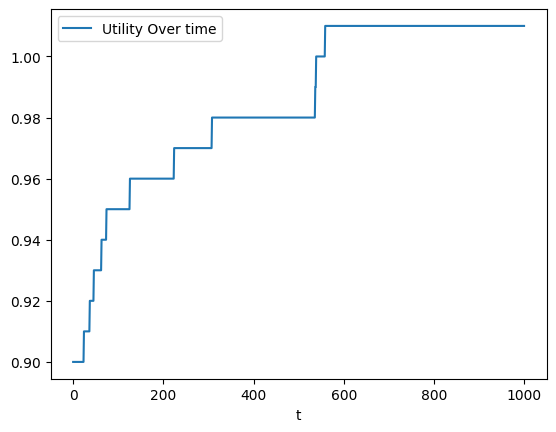

In [7]:
#Extract data from the Model records (the utility):
data = results.variables.VaccumModel
#plot this data
ax = data.plot()

In [8]:
#Also print the Optimal Steps from the Agents final records:
print(results.variables.VaccumAgent)

             optimal steps
obj_id t                  
1      1000            539
